<strong>*Jupyter notebook that demonstrates how to download and use Cryotempo-EOLIS data, downloaded from cs2eo.org. Here, we will read in some point data and then plot a timeseries*</strong>
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


To run this notebook, you will need to make sure that the folllowing packages are installed in your python environment (all can be installed via pip/conda)

    - matplotlib
    - pandas: for dataframe manipulation
    - netCDF4: for handing NetCDF files
    - glob
    - datetime: for handling timestamps
    - dateutil: for timseries generation
    - numpy

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

<strong>1) Download Data

If you have downloaded this notebook to your local drive, then you will also need to download some data. You can use this notebook to plot any CryoTEMPO-EOLIS point data that you choose. For a quick example, follow the below instructions to download a small example dataset.</strong>

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

Imports necessary to run the rest of the code

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc
import glob
import datetime
from dateutil.relativedelta import *
import numpy as np
import matplotlib.dates as mdate
import os
import platform
from ftplib import FTP
import sys

<strong>The following four cells contain the python script necessary to download the results of the query described above from the ESA FTP servers. It is taken verbatim from the script generated by a cs2eo query - one could run said script in place of these 4 cells, for any query of your choice. The data is downloaded to your current working directory. This query will download 11 files containing point product data for the Jakobshavn glacier in Greenland.</strong>

These functions contain specific methods needed to complete the data download:

In [2]:
def file_byte_handler(data):
    global download_file_obj, read_byte_count, total_byte_count
    download_file_obj.write(data)
    read_byte_count = read_byte_count + len(data)
    progress_bar(read_byte_count, total_byte_count)


def progress_bar(progress, total, prefix="", size=60, file=sys.stdout):
    if total != 0:
        x = int(size*progress/total)
        x_percent = int(100*progress/total)
        file.write(f" {prefix} [{'='*x}{' '*(size-x)}] {x_percent} % \r")
        file.flush()

First, we list the files that we want to download. These are generated automatically by a cs2eo.org query.

In [3]:
esa_files =  ['/TEMPO_SWATH_POINT/2021/09/GREENLAND/CS_OFFL_THEM_POINT_GREENLAND_2021_09_-200000___-2300000__V002.nc', '/TEMPO_SWATH_POINT/2022/03/GREENLAND/CS_OFFL_THEM_POINT_GREENLAND_2022_03_-200000___-2300000__V003.nc', '/TEMPO_SWATH_POINT/2021/08/GREENLAND/CS_OFFL_THEM_POINT_GREENLAND_2021_08_-200000___-2300000__V002.nc', '/TEMPO_SWATH_POINT/2021/10/GREENLAND/CS_OFFL_THEM_POINT_GREENLAND_2021_10_-200000___-2300000__V002.nc', '/TEMPO_SWATH_POINT/2021/12/GREENLAND/CS_OFFL_THEM_POINT_GREENLAND_2021_12_-200000___-2300000__V002.nc', '/TEMPO_SWATH_POINT/2022/05/GREENLAND/CS_OFFL_THEM_POINT_GREENLAND_2022_05_-200000___-2300000__V002.nc', '/TEMPO_SWATH_POINT/2021/05/GREENLAND/CS_OFFL_THEM_POINT_GREENLAND_2021_05_-200000___-2300000__V002.nc', '/TEMPO_SWATH_POINT/2022/02/GREENLAND/CS_OFFL_THEM_POINT_GREENLAND_2022_02_-200000___-2300000__V002.nc', '/TEMPO_SWATH_POINT/2021/11/GREENLAND/CS_OFFL_THEM_POINT_GREENLAND_2021_11_-200000___-2300000__V002.nc', '/TEMPO_SWATH_POINT/2021/07/GREENLAND/CS_OFFL_THEM_POINT_GREENLAND_2021_07_-200000___-2300000__V002.nc', '/TEMPO_SWATH_POINT/2022/01/GREENLAND/CS_OFFL_THEM_POINT_GREENLAND_2022_01_-200000___-2300000__V002.nc', '/TEMPO_SWATH_POINT/2022/04/GREENLAND/CS_OFFL_THEM_POINT_GREENLAND_2022_04_-200000___-2300000__V002.nc', '/TEMPO_SWATH_POINT/2021/06/GREENLAND/CS_OFFL_THEM_POINT_GREENLAND_2021_06_-200000___-2300000__V002.nc']
download_file_obj = None
read_byte_count = None
total_byte_count = None

Next, we must provide an email address to access the ESA FTP server. Input your email into the prompt that appears below.

In [4]:
email = input("Please enter your e-mail: ")

Finally, we connect to the server, supply our email address and download the data to our current working directory. This process should take a couple of minutes. The progress of the download will be shown below.

In [5]:
print("About to connect to ESA science server")
# Open the FTP connection
with FTP("science-pds.cryosat.esa.int") as ftp:
    try:
        #Login using your email address
        ftp.login("anonymous", email)
        print("Downloading {} files".format(len(esa_files)))
        # Step through the files that we want to download    
        for i, filename in enumerate(esa_files):
            padded_count = str(i+1).zfill(len(str(len(esa_files))))
            # Print some details about the progress of the download
            print("{}/{}. Downloading file {}".format(padded_count, len(esa_files), os.path.basename(filename)))
            with open(os.path.basename(filename), 'wb') as download_file:
                download_file_obj = download_file
                total_byte_count = ftp.size(filename)
                read_byte_count = 0
                ftp.retrbinary('RETR ' + filename, file_byte_handler, 1024)
            print("\n")
    # After downloading all of the files, close the FTP connection
    finally:
        print("Exiting FTP.")
        ftp.quit()

About to connect to ESA science server
01/13. Downloading file CS_OFFL_THEM_POINT_GREENLAND_2021_09_-200000___-2300000__V002.nc
  [============================================================] 100 % 

02/13. Downloading file CS_OFFL_THEM_POINT_GREENLAND_2022_03_-200000___-2300000__V003.nc
  [============================================================] 100 % 

03/13. Downloading file CS_OFFL_THEM_POINT_GREENLAND_2021_08_-200000___-2300000__V002.nc
  [============================================================] 100 % 

04/13. Downloading file CS_OFFL_THEM_POINT_GREENLAND_2021_10_-200000___-2300000__V002.nc
  [============================================================] 100 % 

05/13. Downloading file CS_OFFL_THEM_POINT_GREENLAND_2021_12_-200000___-2300000__V002.nc
  [============================================================] 100 % 

06/13. Downloading file CS_OFFL_THEM_POINT_GREENLAND_2022_05_-200000___-2300000__V002.nc
  [===========================================================

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
<strong>2) Load downloaded data into python</strong>

<strong>Now that we have downloaded the data, we can use python to visualise it. In the remainder of this demo notebook, we will load the data that we have just downloaded into python, and then use it to generate a timeseries of elevation change in the Jakobshavn glacier over the last year.</strong> 

If you have downloaded the notebook onto your local machine, you will need to edit the filepath below to point to the location of the downloaded data. We will then locate and store the names of each of the point data files. The point data is stored in *netcdf* files, which have the suffix .nc

In [79]:
data_filepath = '/home/dubbersophie/ew_code/extra_stuff_for_eolis_demo/point_data/'
#data_filepath = '/content/' #Filepath specific to the Google Colab environment
files = sorted(glob.glob(data_filepath+'/*.nc'))

<strong>Now that the files containing the data have been located, we will load the data that they contain into python, one file at a time.</strong> 


In [80]:
list_of_dataframes_from_netcdfs = []

The following code opens each netcdf file, reads in the data associated with each variable, and stores this data in the column of a dataframe. The loop below does this for all of the point data files in our current directory.

In [81]:
for i in range(len(files)):
    data = {}
    with nc.Dataset(files[i]) as netcdf:
        for column in netcdf.variables:
            rows_from_nc = netcdf.variables[column]
            data[column] = pd.Series(rows_from_nc[:])
    df = pd.DataFrame(data)        
    list_of_dataframes_from_netcdfs.append(df)

After loading in the data from each individual file returned by the point product query, we will combine them into one dataframe. 

In [82]:
full_query_results = pd.concat(list_of_dataframes_from_netcdfs)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
<strong>3. Investigate the point product</strong>

<strong>Now that the data has been loaded into the notebook, and stored in a dataframe, we can create some visuals that allow us to quickly understand the scope of the point product and its capabilities.</strong>

Next, we can establish the scale and scope of the data included in 11 months of the point product. If we run the cell below, we can see that this query contains 1,647,427 data points. Additionally, the variables available for analysis include a time, x and y position, elevation and an associated uncertainty value. For more information about the derivation of these variables, see ...(DOCS)....

In [91]:
# Dataframe meta data that describes results of query
print('Number of points in query =', len(full_query_results))
print('Variables returned by query: ', full_query_results.columns)

Number of points in query = 1647427
Variables returned by query:  Index(['time', 'x', 'y', 'elevation', 'uncertainty', 'isSwath', 'inputfileid'], dtype='object')


Next, we will make a simple spatial plot of the point product that we have downloaded. This plot shows all point data available for the Jakobshavn glacier in the timeframe that we specified for the query, and demonstrates the spatial coverage achieved using SWATH processing. The scatter points are colour-coded by their elevations. For more information on the observing tracks of CryoSat, and swath processing, see .....

Text(0, 0.5, 'y [m]')

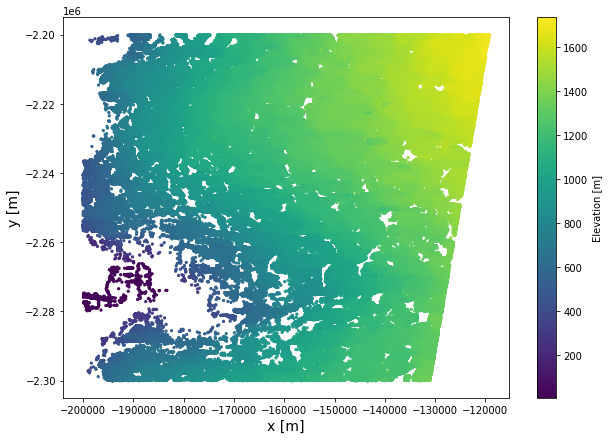

In [92]:
fig, axs = plt.subplots(1,1,figsize=(10,7))

c = axs.scatter(full_query_results['x'], full_query_results['y'], c=full_query_results['elevation'], s=5, cmap='viridis')
plt.colorbar(c, label='Elevation [m]')
axs.set_xlabel('x [m]',fontsize=14)
axs.set_ylabel('y [m]',fontsize=14)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
<strong>4. Use the Cryotempo-EOLIS point product to plot a timeseries for this area of Greenland</strong>

<strong>Finally, we will use the query dataframe to generate an elevation timeseries for the Jakobshavn glacier, covering the short time period May 2021 - May 2022. If the user is looking for a more extensive temporal dataset, the Greenland and Antarctic regions have point products available dating back to July 2010. </strong>

A timeseries is a tool used to visualise the change in a variable over time. In this instance, we will visualise the change in elevation, which can be caused by seasonal temperature variations, or ... (see .... for more details). To smooth the resulting timeseries and account for data gaps, the elevation value for each month is calculated using a 3 month span: i.e. the month before, the month itself and the month after (June, July and August contribute to the July data point). 


In [99]:
interval = 90.
medians, errors = [], []
column = 'elevation'
tile_size = 2000

We mask the dataframe to extract points for a 5km x 5 km area. We define the minimum and maximum x and y values, and 

In [61]:
min_x, max_x, min_y, max_y = -170000, -160000, -2280000, -2270000
full_query_results = full_query_results[(full_query_results['x'] >= min_x) & (full_query_results['x'] <= max_x) & (full_query_results['y'] >= min_y) & (full_query_results['y'] <= max_y)]

Next, we extract a list of dates that have associated data points in our query dataframe. To do this, we make use of the datetime python package, to convert the *timestamps* provided by the EOLIS data into *years, months and days*

In [100]:
time_list = full_query_results['time']
time_bins = full_query_results.time.unique()
time_bins.sort()
dates = []
    
for i in range(len(time_bins)):
    timestamp = datetime.datetime.fromtimestamp(time_bins[i])
    dates.append(timestamp)

In the loop below, we calculate the median elevation value for all of the data within each 90 day interval i.e. for September 2021, we calculate the median elevation for all data between August 2021 and October 2021. We also use the pandas .sem() method to calculate the standard error of the median elevation using all data within this timeframe.

In [95]:
for idx, date in enumerate(dates):
    startdate = datetime.datetime.timestamp(date-relativedelta(days=+(interval/2)))
    enddate = datetime.datetime.timestamp(date+relativedelta(days=+(interval/2)))
    df_filt = full_query_results[(full_query_results.time >= startdate) & (full_query_results.time < enddate)].reindex()

    medians.append(np.nanmedian(df_filt[column]))
    errors.append(df_filt[column].sem())

After calcating the median elevation value and corresponding error for each month within the specified time period, we can apply some basic filtering to the timeseries to remove any obvious outliers. Firstly, we remove all points that are more than 3 standard deviations away from the mean elevation value. Then, ....?

In [102]:
medians = np.where(np.abs(np.array(medians)-np.nanmean(medians)) <= (3*np.nanstd(medians)), np.array(medians), np.nan)
medians = np.where(np.array(errors) <= 3, np.array(medians), np.nan)

Finally, having cleaned our timeseries, we can store it in a new dataframe.

In [103]:
timeseries_df = pd.DataFrame()
timeseries_df['dates'] = dates
timeseries_df['medians'] = medians
timeseries_df['errors'] = errors

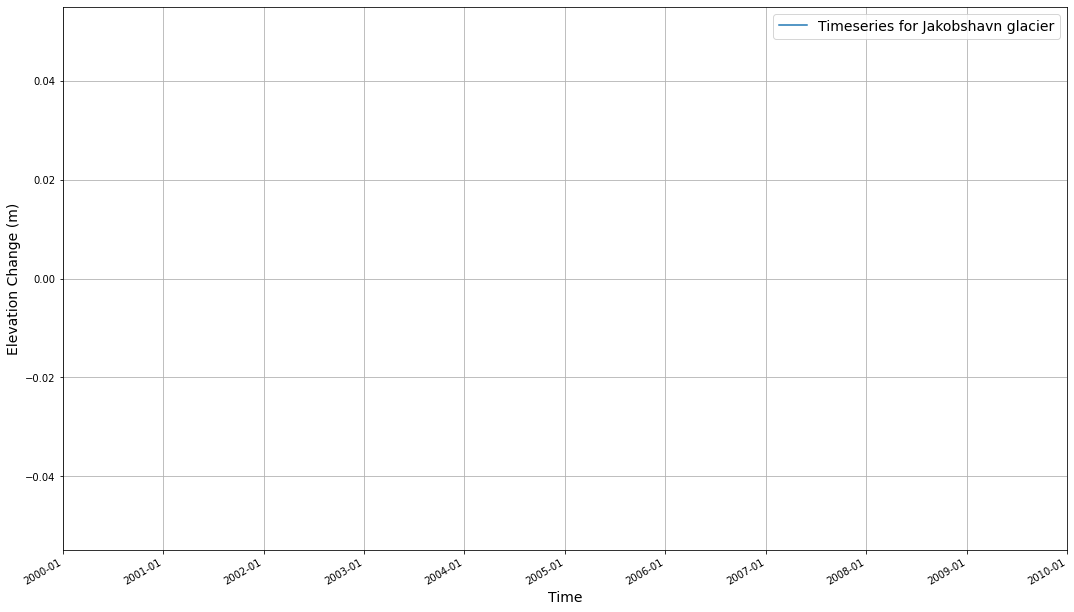

In [104]:
# Plot the timeseries dataframe
fig, axs = plt.subplots(1,1,figsize=(18,10))

#axs.plot(timeseries_df['dates'],timeseries_df['medians'][0] - timeseries_df['medians'], label='Timeseries for Jakobshavn glacier')
axs.plot(timeseries_df['dates'], timeseries_df['medians'], label='Timeseries for Jakobshavn glacier')
axs.set_ylabel('Elevation Change (m)',fontsize=14)
axs.set_xlabel('Time',fontsize=14)

axs.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
for label in axs.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
axs.grid(visible=True) 
plt.legend(fontsize=14)